In [1]:
# --- 1. ติดตั้งไลบรารีที่จำเป็น ---
!pip install seqeval -q
!pip install evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.0 MB/s eta 0:00:00


In [2]:
# --- 2. Import ไลบรารีทั้งหมด ---
import json
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from datasets import Dataset, DatasetDict, Features, Sequence, ClassLabel, Value, load_from_disk
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.nn import CrossEntropyLoss
from transformers import (
    AutoModelForTokenClassification,
    AutoTokenizer,
    DataCollatorForTokenClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

In [3]:
# --- 3. ตั้งค่าและโหลดข้อมูล ---
print("กำลังโหลดข้อมูล...")
# !! แก้ "your-dataset-name" เป็นชื่อ Dataset ของคุณบน Kaggle !!
PROCESSED_DATA_PATH = Path("/kaggle/input/techstack-ner-dataset")

if not PROCESSED_DATA_PATH.exists():
    print("ไม่พบข้อมูลที่ path ที่กำหนด สร้างข้อมูลจำลองสำหรับการทดสอบ...")
    # สร้างข้อมูลจำลอง
    dummy_data = {
        "train": Dataset.from_dict({"input_ids": [[1,2,3]], "attention_mask": [[1,1,1]], "labels": [[0,1,2]]}),
        "validation": Dataset.from_dict({"input_ids": [[1,2,3]], "attention_mask": [[1,1,1]], "labels": [[0,1,2]]})
    }
    final_datasets = DatasetDict(dummy_data)
    label_names = ["FAL", "PSML", "TAS"] # ตัวอย่าง
else:
    final_datasets = load_from_disk(str(PROCESSED_DATA_PATH))
    with open(PROCESSED_DATA_PATH / "label_mappings.json", "r") as f:
        mappings = json.load(f)
    id2label = {int(k): v for k, v in mappings["id2label"].items()}
    label2id = mappings["label2id"]
    label_names = mappings["label_names"]

print("โหลดข้อมูลสำเร็จ!")
print(f"Dataset structure:\n{final_datasets}")
print("-" * 50)

กำลังโหลดข้อมูล...
โหลดข้อมูลสำเร็จ!
Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2049
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 228
    })
})
--------------------------------------------------


In [4]:
# --- 4. โหลด Tokenizer และ Model ---
print("กำลังโหลด Tokenizer และ Model...")
MODEL_CHECKPOINT = "roberta-large" # เปลี่ยนเป็น large
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, add_prefix_space=True)

model = AutoModelForTokenClassification.from_pretrained(
    MODEL_CHECKPOINT, 
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id
)

print("โหลด Tokenizer และ Model สำเร็จ")
print("-" * 50)

กำลังโหลด Tokenizer และ Model...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


โหลด Tokenizer และ Model สำเร็จ
--------------------------------------------------


In [5]:
# --- 5. จัดการ Class Imbalance และสร้าง Custom Trainer (ฉบับแก้ไขล่าสุด) ---
print("กำลังตั้งค่าสำหรับจัดการ Class Imbalance...")

def calculate_class_weights_improved(dataset, label_list):
    """
    คำนวณ class weights ที่ปรับปรุงแล้ว
    """
    # รวบรวม labels ทั้งหมดจาก training set (ไม่รวม -100)
    all_labels = [label for example in dataset["train"] for label in example["labels"] if label != -100]
    
    # นับจำนวนของแต่ละ class
    label_counts = Counter(all_labels)
    print(f"จำนวน samples ทั้งหมด: {len(all_labels)}")
    print("การกระจายของ labels:")
    for i, label_name in enumerate(label_list):
        count = label_counts.get(i, 0)
        percentage = (count / len(all_labels)) * 100 if len(all_labels) > 0 else 0
        print(f"  {label_name}: {count} samples ({percentage:.2f}%)")
    
    # วิธีที่ 1: ใช้ sklearn's compute_class_weight (แนะนำ)
    unique_labels = sorted(list(set(all_labels)))
    class_weights_sklearn = compute_class_weight(
        class_weight='balanced',
        classes=np.array(unique_labels),
        y=np.array(all_labels)
    )
    
    # สร้าง weight tensor สำหรับทุก class (len(label_list))
    weights_array = np.ones(len(label_list))
    sklearn_map = {label: weight for label, weight in zip(unique_labels, class_weights_sklearn)}
    for i in range(len(label_list)):
        if i in sklearn_map:
            weights_array[i] = sklearn_map[i]
    
    # วิธีที่ 2: คำนวณแบบ inverse frequency
    total_samples = len(all_labels)
    num_classes = len(label_list)
    weights_inverse = [
        total_samples / (num_classes * label_counts.get(i, 1)) for i in range(num_classes)
    ]
    
    # วิธีที่ 3: คำนวณแบบ square root inverse frequency (นุ่มกว่า)
    weights_sqrt = [
        np.sqrt(total_samples / (num_classes * label_counts.get(i, 1))) for i in range(num_classes)
    ]
    
    return {
        'sklearn_balanced': torch.tensor(weights_array, dtype=torch.float32),
        'inverse_frequency': torch.tensor(weights_inverse, dtype=torch.float32),
        'sqrt_inverse': torch.tensor(weights_sqrt, dtype=torch.float32),
        'label_counts': label_counts
    }

# สร้าง Custom Trainer ที่แก้ไขแล้ว
class ImprovedCustomTrainer(Trainer):
    def __init__(self, class_weights=None, label_smoothing=0.0, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        device = inputs["input_ids"].device
        
        loss_fct = CrossEntropyLoss(
            weight=self.class_weights.to(device) if self.class_weights is not None else None,
            label_smoothing=self.label_smoothing,
            ignore_index=-100
        )
        
        # [FIX] ตรวจสอบว่า model ถูก wrap ด้วย DataParallel หรือไม่
        # ถ้าใช่ ให้ใช้ model.module เพื่อเข้าถึง model ตัวจริง
        actual_model = model.module if hasattr(model, 'module') else model
        
        # คำนวณ loss โดยใช้ actual_model
        loss = loss_fct(
            logits.view(-1, actual_model.config.num_labels), # <--- แก้จาก model เป็น actual_model
            labels.view(-1)
        )
        
        return (loss, outputs) if return_outputs else loss

print("Custom Trainer รูปแบบใหม่พร้อมใช้งาน")
print("-" * 50)

กำลังตั้งค่าสำหรับจัดการ Class Imbalance...
Custom Trainer รูปแบบใหม่พร้อมใช้งาน
--------------------------------------------------


In [6]:
# --- 5.1 เปรียบเทียบวิธีการคำนวณ Class Weights ---
def test_different_weights(dataset, label_list):
    print("\n" + "="*60)
    print("เปรียบเทียบวิธีการคำนวณ Class Weights")
    print("="*60)
    
    weights_info = calculate_class_weights_improved(dataset, label_list)
    
    methods = ['sklearn_balanced', 'inverse_frequency', 'sqrt_inverse']
    
    for method in methods:
        weights = weights_info[method]
        print(f"\n{method.upper()}:")
        
        # คำนวณ ratio เพื่อดูการปรับสมดุล
        max_weight = torch.max(weights)
        min_weight_non_zero = torch.min(weights[weights>0])
        ratio = max_weight / min_weight_non_zero if min_weight_non_zero > 0 else float('inf')
        
        print(f"  Weight range: {min_weight_non_zero:.4f} - {max_weight:.4f}")
        print(f"  Ratio (max/min): {ratio:.2f}")
        
        # แสดง weights ที่สำคัญ
        for i, (label_name, weight) in enumerate(zip(label_list, weights)):
            if weights_info['label_counts'].get(i, 0) > 0: # แสดงเฉพาะ class ที่มีข้อมูล
                print(f"    {label_name}: {weight:.4f}")
    
    return weights_info

# เรียกใช้ฟังก์ชันทดสอบ
weights_comparison = test_different_weights(final_datasets, label_names)


เปรียบเทียบวิธีการคำนวณ Class Weights
จำนวน samples ทั้งหมด: 215185
การกระจายของ labels:
  B-CP: 2226 samples (1.03%)
  B-DB: 2253 samples (1.05%)
  B-ET: 176 samples (0.08%)
  B-FAL: 12552 samples (5.83%)
  B-PSML: 6913 samples (3.21%)
  B-TAS: 12669 samples (5.89%)
  I-CP: 571 samples (0.27%)
  I-DB: 583 samples (0.27%)
  I-ET: 60 samples (0.03%)
  I-FAL: 3576 samples (1.66%)
  I-PSML: 647 samples (0.30%)
  I-TAS: 13234 samples (6.15%)
  O: 159725 samples (74.23%)

SKLEARN_BALANCED:
  Weight range: 0.1036 - 275.8782
  Ratio (max/min): 2662.08
    B-CP: 7.4361
    B-DB: 7.3470
    B-ET: 94.0494
    B-FAL: 1.3187
    B-PSML: 2.3944
    B-TAS: 1.3066
    I-CP: 28.9890
    I-DB: 28.3923
    I-ET: 275.8782
    I-FAL: 4.6288
    I-PSML: 25.5838
    I-TAS: 1.2508
    O: 0.1036

INVERSE_FREQUENCY:
  Weight range: 0.1036 - 275.8782
  Ratio (max/min): 2662.08
    B-CP: 7.4361
    B-DB: 7.3470
    B-ET: 94.0494
    B-FAL: 1.3187
    B-PSML: 2.3944
    B-TAS: 1.3066
    I-CP: 28.9890
    I-DB: 

In [7]:
# --- 6. สร้างฟังก์ชันสำหรับวัดผล (compute_metrics) ---
seqeval = evaluate.load("seqeval")
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # แปลง ID กลับเป็น Label และลบ Padding (-100) ออก
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # คำนวณผลลัพธ์ด้วย seqeval
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    
    # คืนค่าเฉพาะเมตริกหลักๆ ที่เราสนใจ
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

print("ฟังก์ชัน `compute_metrics` พร้อมแล้ว")
print("-" * 50)

ฟังก์ชัน `compute_metrics` พร้อมแล้ว
--------------------------------------------------


In [8]:
# --- 7. ตั้งค่า Training Arguments (สำหรับ roberta-large) ---
print("กำลังตั้งค่า Training Arguments สำหรับ roberta-large...")
training_args = TrainingArguments(
    output_dir="./roberta-large-ner-results",
    num_train_epochs=8, # ตั้งเพดานสูงสุดไว้ที่ 8
    learning_rate=2e-5, 
    weight_decay=0.01,
    
    # ลด Batch Size และใช้ Gradient Accumulation สำหรับโมเดลขนาดใหญ่
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    
    warmup_ratio=0.1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    
    # ใช้ loss เป็นเกณฑ์ในการเลือกโมเดลที่ดีที่สุดและหยุดการเทรน
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,
    load_best_model_at_end=True,
    
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    push_to_hub=False,
)
print("ตั้งค่า Training Arguments สำเร็จ")
print("-" * 50)

กำลังตั้งค่า Training Arguments สำหรับ roberta-large...
ตั้งค่า Training Arguments สำเร็จ
--------------------------------------------------


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [9]:
# --- 8. สร้างและเริ่มการ Train ---
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = ImprovedCustomTrainer(
    model=model,
    args=training_args,
    train_dataset=final_datasets["train"],
    eval_dataset=final_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    
    # ส่ง class weights และ label smoothing เข้าไป
    class_weights=weights_comparison['sqrt_inverse'],
    label_smoothing=0.1
)

trainer.train()

<ipython-input-5-bb48501f9bf3>:57: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `ImprovedCustomTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,3.454200,2.686703,0.579975,0.800849,0.672746,0.842740
2,2.696600,2.608078,0.672309,0.802845,0.731802,0.883138
3,2.625000,2.586140,0.678769,0.825805,0.745102,0.878144
4,2.569600,2.585634,0.671227,0.844772,0.748066,0.874077
5,2.524500,2.592136,0.677003,0.850012,0.753707,0.870409
6,2.487000,2.580066,0.719175,0.844273,0.776719,0.891094
7,2.442400,2.584957,0.731733,0.852259,0.787411,0.896221


TrainOutput(global_step=512, training_loss=2.6316872760653496, metrics={'train_runtime': 1795.9615, 'train_samples_per_second': 9.127, 'train_steps_per_second': 0.285, 'total_flos': 7733558986143696.0, 'train_loss': 2.6316872760653496, 'epoch': 7.883720930232558})

กำลังประเมินผลและสร้าง Confusion Matrix บนชุดข้อมูล Validation...


Confusion Matrix data ถูกบันทึกเป็นไฟล์ CSV ที่: './confusion_matrix.csv'
Confusion Matrix ถูกบันทึกเป็นรูปภาพที่: './confusion_matrix.png'


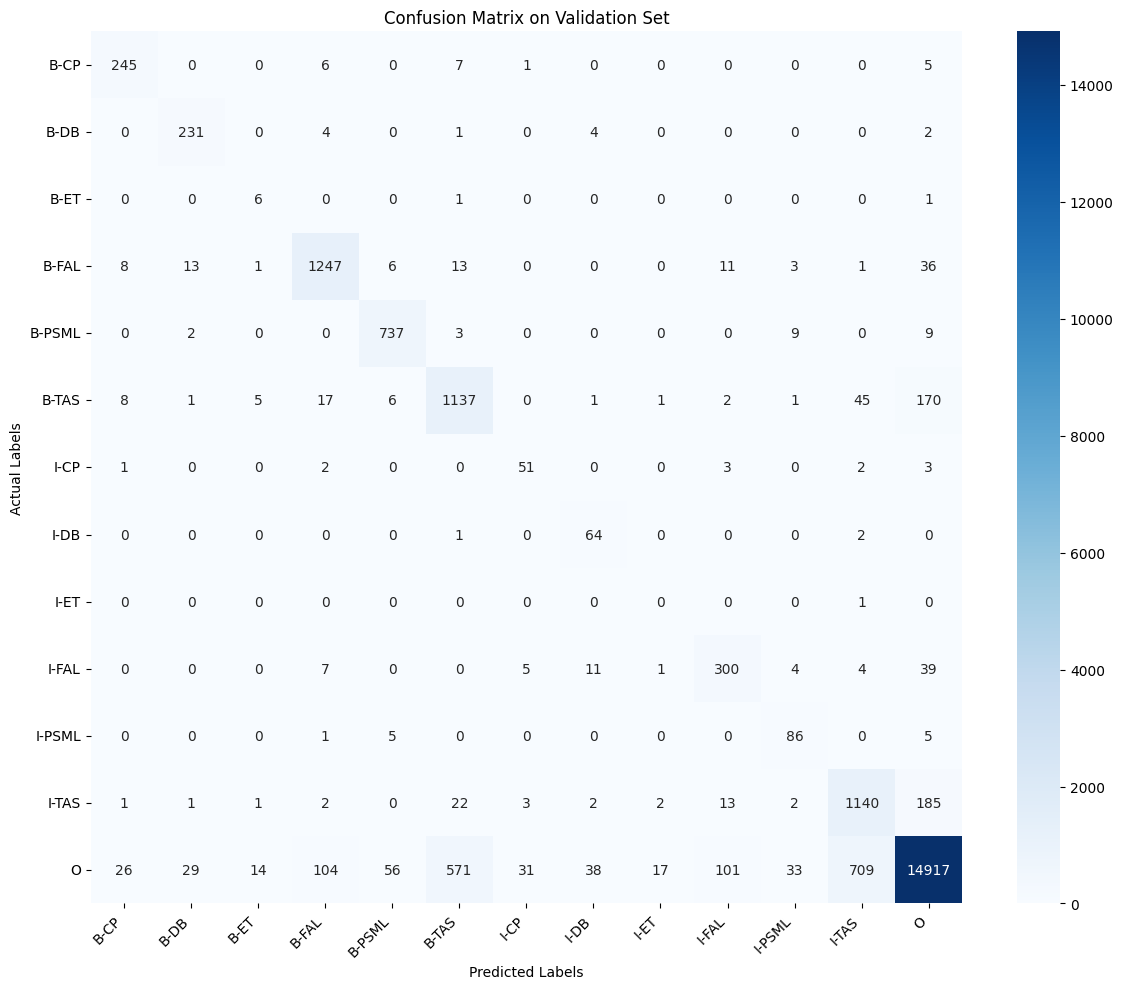

In [10]:
# --- 9. สร้างและบันทึก Confusion Matrix ---
print("กำลังประเมินผลและสร้าง Confusion Matrix บนชุดข้อมูล Validation...")

# 1. ทำนายผลบน validation set
predictions, labels, _ = trainer.predict(final_datasets["validation"])
preds = np.argmax(predictions, axis=2)

# 2. กรองเอาเฉพาะ label จริง (ไม่เอา -100)
true_predictions = [
    label_names[p]
    for prediction, label in zip(preds, labels)
    for (p, l) in zip(prediction, label)
    if l != -100
]
true_labels = [
    label_names[l]
    for prediction, label in zip(preds, labels)
    for (p, l) in zip(prediction, label)
    if l != -100
]

# 3. สร้าง Confusion Matrix
cm = confusion_matrix(true_labels, true_predictions, labels=label_names)
cm_df = pd.DataFrame(cm, index=label_names, columns=label_names)

# 4. บันทึกข้อมูล Matrix เป็นไฟล์ CSV
cm_csv_path = "./confusion_matrix.csv"
cm_df.to_csv(cm_csv_path)
print(f"Confusion Matrix data ถูกบันทึกเป็นไฟล์ CSV ที่: '{cm_csv_path}'")

# 5. พลอตและบันทึกรูปภาพ
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()

# บันทึกรูปภาพ
cm_image_path = "./confusion_matrix.png"
plt.savefig(cm_image_path)
print(f"Confusion Matrix ถูกบันทึกเป็นรูปภาพที่: '{cm_image_path}'")
plt.show()

print("=" * 50)

In [11]:
# --- 10. บันทึกโมเดลที่ดีที่สุด ---
output_model_dir = Path("./best_model")
trainer.save_model(str(output_model_dir))
tokenizer.save_pretrained(str(output_model_dir))
print(f"โมเดลและ Tokenizer ที่ดีที่สุดถูกบันทึกไว้ที่: '{output_model_dir}'")

โมเดลและ Tokenizer ที่ดีที่สุดถูกบันทึกไว้ที่: 'best_model'
